In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.ops import unary_union
import scienceplots
import dynamic_tasker.schedulers as schedulers
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

plt.style.use(['science'])
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage[T1]{fontenc}
    \usepackage{XCharter}
    \usepackage[charter,vvarbb,scaled=1.05]{newtxmath}
'''
%load_ext autoreload
%autoreload 2

In [2]:
def add_meteorelogical_sat(center_lon, ax, color, label, inner_limit=None):
    
    # Define the center of the circle (latitude, longitude) and the radius in kilometers
    center_lat = 0  # Latitude of the center point

    R_E = 6378
    h = 35786

    alfa = np.arcsin((R_E)/(R_E + h))
    beta = np.pi/2 - alfa
    r = R_E * beta
    radius_km = r

    # Create a geodesic object
    geod = Geodesic()

    # Compute the circle points
    circle = geod.circle(lon=center_lon, lat=center_lat, radius=radius_km * 1000, n_samples=200)

    # Extract the longitude and latitude points
    lon_circle, lat_circle = zip(*circle)

    lon_circle = list(lon_circle)
    lat_circle = list(lat_circle)
    lon_circle.append(lon_circle[0])
    lat_circle.append(lat_circle[0])
    lon_circle = np.array(lon_circle)
    lat_circle = np.array(lat_circle)

    if(center_lon < 0):
        lon_circle[lon_circle>=90] -= 360
    elif(center_lon > 180 - 67.5):
        lon_circle[lon_circle<0] += 360

    # Plot the circle on the map
    ax.plot(lon_circle, lat_circle, color=color, transform=ccrs.Geodetic(), linestyle='--')

    # Create and add a filled polygon patch for the circle
    poly = Polygon(np.column_stack((lon_circle, lat_circle)), color=color, alpha=0.2, transform=ccrs.PlateCarree())
    ax.add_patch(poly)

    if(inner_limit):
        inner_radius_km = np.radians(inner_limit) * R_E
        inner_circle = geod.circle(lon=center_lon, lat=center_lat, radius=inner_radius_km * 1000, n_samples=200)
        lon_inner_circle, lat_inner_circle = zip(*inner_circle)
        lon_inner_circle = list(lon_inner_circle)
        lat_inner_circle = list(lat_inner_circle)
        lon_inner_circle.append(lon_inner_circle[0])
        lat_inner_circle.append(lat_inner_circle[0])
        lon_inner_circle = np.array(lon_inner_circle)
        lat_inner_circle = np.array(lat_inner_circle)

        if(center_lon < 0):
            lon_inner_circle[lon_inner_circle>=90] -= 360
        elif(center_lon > 180 - 67.5):
            lon_inner_circle[lon_inner_circle<0] += 360

        ax.plot(lon_inner_circle, lat_inner_circle, color=color, transform=ccrs.Geodetic())
    # Plot the center point
    ax.plot(center_lon, center_lat, '.', color=color, transform=ccrs.Geodetic(), label=label)




Tight axes size (inches): 7.164120152873635 3.6960677646749387


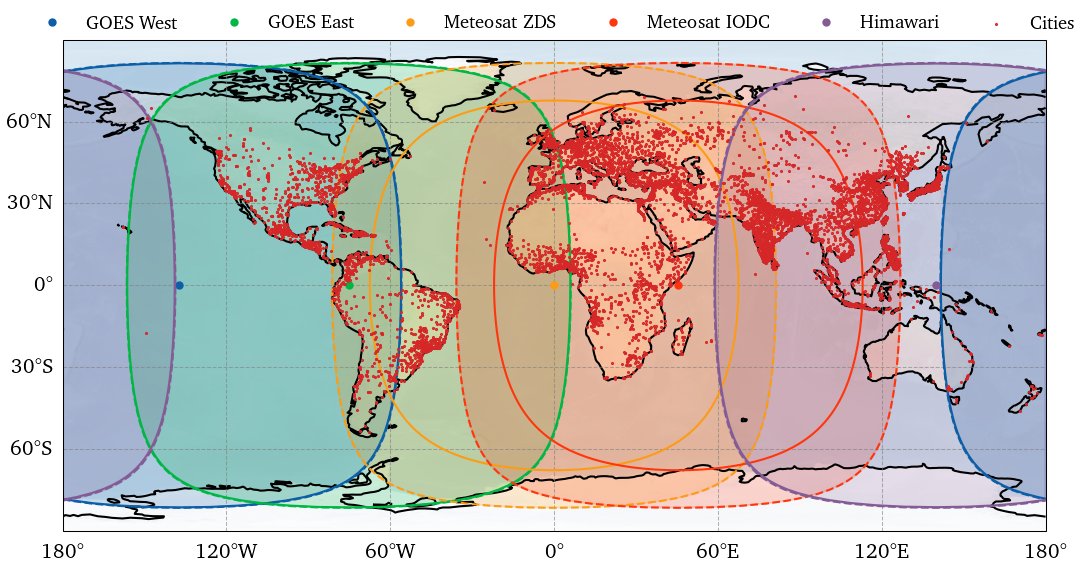

In [5]:
%matplotlib inline

labels = ["GOES West", "GOES East", "Meteosat ZDS", "Meteosat IODC", "Himawari"]
# labels = ["Himawari"]
center_lons = [-137.2, -75.2, 0, 45.5, 140.]
# center_lons = [140.7]
colors = ["#0c5ea6", "#00b746", "#fc9c16", "#ff360d", "#845c95"]
inner_limit = [81.14, 81.14, 67.5, 67.5, 81.05]

# Create a map with Cartopy
fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
ax.set_global()

# Add features to the map
ax.stock_img(alpha=0.3)
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.6, zorder=3)
gl.top_labels = False
gl.right_labels = False
[add_meteorelogical_sat(x, ax, y, z, r) for x, y, z, r in zip(center_lons, colors, labels, inner_limit)]

cities = schedulers.load_worldcities(10000)
cities_lats = [x.lat for x in cities]
cities_lons = [x.long for x in cities]

ax.scatter(cities_lons, cities_lats, s=1, transform=ccrs.PlateCarree(), label='Cities', zorder=10, marker='.', color='tab:red')
# Add a title and a legend
ax.legend(ncol=6, bbox_to_anchor=(0.5, 0.98), loc='lower center', fontsize=9)
ax.set_aspect(1)
plt.tight_layout()
fig.canvas.draw()
renderer = fig.canvas.get_renderer()
tight_bbox = ax.get_tightbbox(renderer)

dpi=150
tight_width_in = tight_bbox.width / dpi
tight_height_in = tight_bbox.height / dpi
print("Tight axes size (inches):", tight_width_in, tight_height_in)
plt.savefig("meteorological_satellite_coverage.png", dpi=300)
plt.show()

C:\Users\shree\AppData\Local\Temp\ipykernel_33880\2373638488.py:52: RuntimeWarning: divide by zero encountered in divide
  GSD_Reduction[i, j] = np.min([np.min(r_norm / ((cosine_factor) * (R_sat - a)))])


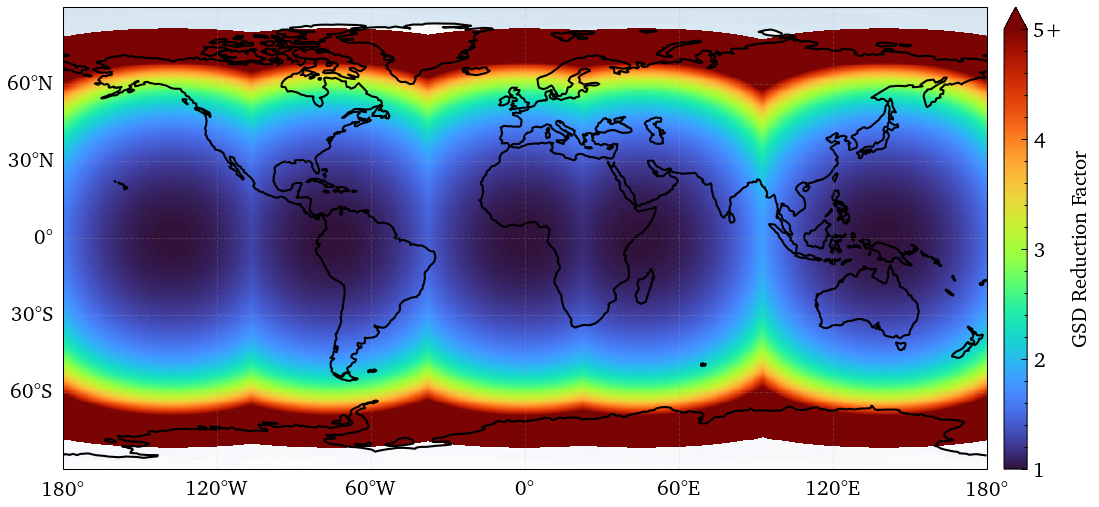

In [6]:
# Now plot the GSD reduction map
def plot_gsd_reduction():
    # Semi-major and semi-minor axes in kilometers
    a = 6378.1370  # Equatorial radius
    b = 6356.7523  # Polar radius

    R_sat = 42164 # Geostationary orbit radius in kilometers

    # Generate latitude and longitude values
    N_lat = 500
    N_lon = 1000
    lat = np.linspace(-90, 90, N_lat)       # Geodetic latitude in degrees
    lon = np.linspace(-180, 180, N_lon)     # Longitude in degrees

    # Create a meshgrid for latitude and longitude
    Lon, Lat = np.meshgrid(lon, lat)
    
    def latlong2ecef(lat, lon, a, b):
        # Convert degrees to radians
        Lat_rad = np.radians(lat)
        Lon_rad = np.radians(lon)
        # First eccentricity squared
        e_sq = (a**2 - b**2) / a**2

        # Compute the radius of curvature in the prime vertical
        N = a / np.sqrt(1 - e_sq * np.sin(Lat_rad)**2)

        # ECEF coordinates
        X = N * np.cos(Lat_rad) * np.cos(Lon_rad)
        Y = N * np.cos(Lat_rad) * np.sin(Lon_rad)
        Z = (N * (1 - e_sq)) * np.sin(Lat_rad)
        
        return np.array([X, Y, Z])

    # ECEF coordinates of points
    LatLongECEF = latlong2ecef(Lat, Lon, a, b)
    # Now, calculate satellite positions
    Sat_ECEF = latlong2ecef(np.zeros_like(center_lons), center_lons, R_sat, R_sat)

    GSD_Reduction = np.zeros((N_lat, N_lon))

    def gsd_reduction(LatLongECEF, Sat_ECEF):
        # Compute the vector between each point and the satellite
        for i in range(N_lat):
            for j in range(N_lon):
                r = Sat_ECEF - LatLongECEF[:, i, j].reshape(3, 1)
                r_norm = np.linalg.norm(r, axis=0)
                cosine_factor = np.dot(r.T, LatLongECEF[:, i, j]) / (np.linalg.norm(r, axis=0) * np.linalg.norm(LatLongECEF[:, i, j]))

                cosine_factor[cosine_factor < 0] = 0
                
                GSD_Reduction[i, j] = np.min([np.min(r_norm / ((cosine_factor) * (R_sat - a)))])

        return GSD_Reduction

    GSD_Reduction = gsd_reduction(LatLongECEF, Sat_ECEF)
    
    fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
    plt.pcolor(lon, lat, GSD_Reduction, cmap='turbo', vmin=1, vmax=5)
    # Add features to the map
    # ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.OCEAN)
    ax.stock_img(alpha=0.3)
    ax.add_feature(cfeature.COASTLINE)

    cb = plt.colorbar(extend='max', fraction=0.045, pad=0.015, shrink=1.0)
    cb.set_label('GSD Reduction Factor')
    # then set the labels for the extended bar:
    ticks = np.linspace(1,5,5)
    labels = [str(i) for i in range(1,5)] + ['5+']
    cb.set_ticks(ticks)
    cb.set_ticklabels(labels)
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.2)
    gl.top_labels = False
    gl.right_labels = False

plot_gsd_reduction()
plt.savefig("gsd_reduction.png", dpi=300)
plt.show()

Calculating 10-min satellite coverage polygons...
Calculating 15-min satellite coverage polygons...
Calculating union of 10-min zones...
  Done.
Calculating union of 15-min zones...
  Done.
Calculating 15-min only zones (difference)...
  Done.
Plotting 15-min only (green) zones with custom alpha...
  Plotted green with face_alpha=0.2, edge_alpha=1.0.
Plotting 10-min (blue) zones with custom alpha...
  Plotted blue with face_alpha=0.2, edge_alpha=1.0.
Loading and plotting cities...
  Cities plotted.
Displaying plot...


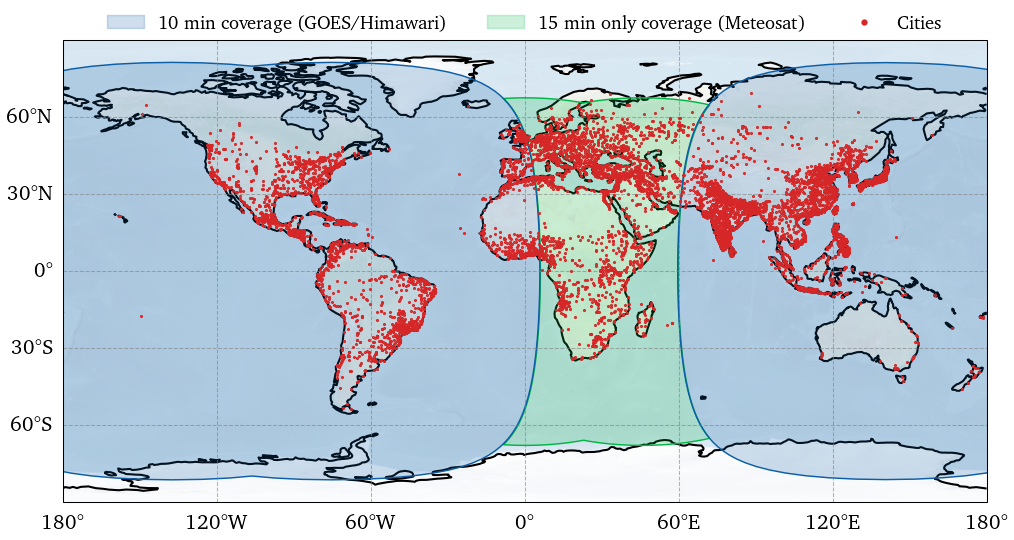

Done.


In [7]:
# --- Helper function (Unchanged) ---
def calculate_coverage_polygon(center_lon, inner_limit, center_lat=0):
    R_E = 6378
    radius_km = np.radians(inner_limit) * R_E
    geod = Geodesic()
    circle_coords = geod.circle(lon=center_lon, lat=center_lat, radius=radius_km * 1000, n_samples=200)
    circle_array = np.array(circle_coords)
    lon_circle, lat_circle = circle_array[:, 0], circle_array[:, 1]
    lon_span = np.ptp(lon_circle)
    if lon_span > 300:
        if center_lon < 0: lon_circle[lon_circle > 0] -= 360
        elif center_lon > 90: lon_circle[lon_circle < 0] += 360
    polygon_points = np.vstack((lon_circle, lat_circle)).T
    polygon_points = np.vstack((polygon_points, polygon_points[0]))
    return ShapelyPolygon(polygon_points)

# --- Modified plotting function ---
def plot_cadence_coverage(ax, lons_10min, lons_15min, limits_10min, limits_15min,
                          color_10min='blue', color_15min_only='green',
                          border_color_10min='darkblue', border_color_15min_only='darkgreen',
                          linewidth=0.8, face_alpha=0.2, edge_alpha=1.0): # Added alpha parameters
    """
    Plots satellite coverage differentiating zones, with independent face/edge alpha.
    """
    polygons_10min = []
    polygons_15min = []

    print("Calculating 10-min satellite coverage polygons...")
    for lon, inner_limit in zip(lons_10min, limits_10min):
        polygons_10min.append(calculate_coverage_polygon(lon, inner_limit=inner_limit))
        # print(f"  Calculated for {lon} deg") # Reduce verbosity

    print("Calculating 15-min satellite coverage polygons...")
    for lon, inner_limit in zip(lons_15min, limits_15min):
        polygons_15min.append(calculate_coverage_polygon(lon, inner_limit=inner_limit))
        # print(f"  Calculated for {lon} deg") # Reduce verbosity

    print("Calculating union of 10-min zones...")
    union_10min = unary_union(polygons_10min) if polygons_10min else ShapelyPolygon()
    print("  Done.")

    print("Calculating union of 15-min zones...")
    union_15min = unary_union(polygons_15min) if polygons_15min else ShapelyPolygon()
    print("  Done.")

    print("Calculating 15-min only zones (difference)...")
    diff_15min_only = union_15min.difference(union_10min) if not union_15min.is_empty else ShapelyPolygon()
    print("  Done.")

    # --- Prepare RGBA colors ---
    face_color_10min_rgba = mcolors.to_rgba(color_10min, alpha=face_alpha)
    edge_color_10min_rgba = mcolors.to_rgba(border_color_10min, alpha=edge_alpha)

    face_color_15min_rgba = mcolors.to_rgba(color_15min_only, alpha=face_alpha)
    edge_color_15min_rgba = mcolors.to_rgba(border_color_15min_only, alpha=edge_alpha)

    # --- Plotting with RGBA Colors ---
    # Note: When using RGBA for face/edgecolor, the main 'alpha' parameter in add_geometries
    #       should ideally be 1 (or omitted) to avoid multiplying the alphas.
    print("Plotting 15-min only (green) zones with custom alpha...")
    if not diff_15min_only.is_empty:
        ax.add_geometries([diff_15min_only], crs=ccrs.PlateCarree(),
                          facecolor=face_color_15min_rgba, # Use RGBA tuple
                          edgecolor=edge_color_15min_rgba, # Use RGBA tuple
                          linewidth=linewidth,
                          label='15 min Only Coverage (Meteosat)')
        print("  Plotted green with face_alpha={}, edge_alpha={}.".format(face_alpha, edge_alpha))
    else:
        print("  No green zones to plot.")

    print("Plotting 10-min (blue) zones with custom alpha...")
    if not union_10min.is_empty:
        ax.add_geometries([union_10min], crs=ccrs.PlateCarree(),
                          facecolor=face_color_10min_rgba, # Use RGBA tuple
                          edgecolor=edge_color_10min_rgba, # Use RGBA tuple
                          linewidth=linewidth,
                          label='10 min Coverage (GOES/Himawari)')
        print("  Plotted blue with face_alpha={}, edge_alpha={}.".format(face_alpha, edge_alpha))
    else:
        print("  No blue zones to plot.")


# --- Main Script ---
sat_lons_10min = [-137.2, -75.2, 140.7]
sat_lons_15min = [0.0, 45.5]
sat_limits_10min = [81.14, 81.14, 81.05]
sat_limits_15min = [67.5, 67.5]

# Define base colors
blue_fill = '#0c5ea6'
green_fill = '#00b746'
blue_border = blue_fill
green_border = green_fill

# --- Set desired alpha values ---
FACE_ALPHA = 0.2
EDGE_ALPHA = 1.0 # Set edge to opaque. If you truly want invisible edge, set this to 0.0

fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
ax.set_global()

# Add features
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
ax.stock_img(alpha=0.3)
ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.6, zorder=3)
gl.top_labels = False
gl.right_labels = False

# Plot the cadence-based coverage with specified alpha values
plot_cadence_coverage(ax, sat_lons_10min, sat_lons_15min,
                      limits_10min=sat_limits_10min, limits_15min=sat_limits_15min,
                      color_10min=blue_fill, color_15min_only=green_fill,
                      border_color_10min=blue_border, border_color_15min_only=green_border,
                      linewidth=0.7,
                      face_alpha=FACE_ALPHA, edge_alpha=EDGE_ALPHA)

# Load and plot cities
print("Loading and plotting cities...")
cities = schedulers.load_worldcities(10000)
cities_lats = [x.lat for x in cities]
cities_lons = [x.long for x in cities]
ax.scatter(cities_lons, cities_lats, s=1, transform=ccrs.PlateCarree(), zorder=4, marker='.', color='tab:red')
print("  Cities plotted.")

# Create custom legend handles - Use the FACE_ALPHA for the patch transparency
legend_handles = [
    mpatches.Patch(facecolor=blue_fill, edgecolor=blue_border if EDGE_ALPHA > 0 else 'none', linewidth=0.7, alpha=FACE_ALPHA, label='10 min coverage (GOES/Himawari)'),
    mpatches.Patch(facecolor=green_fill, edgecolor=green_border if EDGE_ALPHA > 0 else 'none', linewidth=0.7, alpha=FACE_ALPHA, label='15 min only coverage (Meteosat)'),
    plt.Line2D([0], [0], marker='.', color='tab:red', linestyle='', markersize=4, label='Cities')
]

# Add a title and the custom legend
# ax.set_title("Geostationary Satellite Coverage by Scan Cadence", fontsize=12, pad=25)
ax.legend(handles=legend_handles, ncol=3, bbox_to_anchor=(0.5, 0.98), loc='lower center', fontsize=9)

# plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("meteorological_satellite_cadence_coverage_custom_alpha.png", dpi=300, bbox_inches='tight')
print("Displaying plot...")
plt.show()
print("Done.")